# Practical Session: Anomaly Detection and Distribution Drifts


## Introduction

This Jupyter notebook provides a comprehensive, hands-on practical session on anomaly detection and distribution drifts. The content is structured into two main sections: **Anomaly Detection** and **Distribution Drift**. Using real-world datasets and popular Python libraries (e.g., scikit-learn, TensorFlow), we'll implement, evaluate, and mitigate core concepts in these areas.

### Key Learning Objectives
- Implement and compare anomaly detection methods (statistical, distance-based, ML-based).
- Evaluate models using imbalanced metrics (PR-AUC, ROC-AUC, F1) and visualize performance curves.
- Detect and mitigate distribution drifts with incremental learning and statistical tests.
- Address advanced challenges, including adversarial simulations and adaptation strategies.


### Datasets Used
- **Anomaly Detection**: Credit Card Fraud Detection (~284k transactions, 0.17% fraud rate—highly imbalanced).
- **Distribution Drift**: Electricity (Elec2): Real-world stream with abrupt/gradual drifts in electricity price prediction (~45k instances).

## Setup: Install and Import Libraries

This cell installs required packages. Restart the kernel after installation if needed.

In [1]:
! pip install scikit-learn scipy pandas matplotlib seaborn tensorflow shap openml tqdm

pyenv: version `3.10' is not installed (set by /media/jgaspar/7CCE3FA7CE3F589A1/MCS/1_Semester/ai/ai-security-labs/src/08_anomaly/.python-version)


In [2]:
# Imports & utilities
import os, time, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.mixture import GaussianMixture # Using GMM for probabilistic anomaly detection
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp, wasserstein_distance
from tqdm import tqdm

# Keras for autoencoder
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False

print('Tensorflow available:', TF_AVAILABLE)

# Evaluation helper
def pr_auc(y_true, scores):
    prec, rec, _ = precision_recall_curve(y_true, scores)
    return auc(rec, prec)

def evaluate_continuous(y_true, scores, name='score'):
    results = {}
    results['roc_auc'] = roc_auc_score(y_true, scores)
    results['pr_auc'] = pr_auc(y_true, scores)
    return results

def plot_score_vs_label(scores, y, title='Scores'):
    plt.figure(figsize=(8,4))
    sns.histplot(scores[y==0], bins=50, label='normal', stat='density', alpha=0.6, kde=True)
    sns.histplot(scores[y==1], bins=50, label='anomaly', stat='density', alpha=0.6, kde=True)
    plt.legend()
    plt.title(title)
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.show()

print('Setup complete.')

2025-11-14 11:14:28.308928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 11:14:28.366057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow available: True
Setup complete.


2025-11-14 11:14:29.855848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 2. Loading the Datasets

This cell attempts to download datasets from OpenML. If your environment is offline or OpenML fails, place `creditcard.csv` and `electricity.csv` in the working directory and the code will load them.

In [3]:
# Try to fetch datasets from OpenML (non-blocking: will raise if offline)
def load_creditcard_openml():
    try:
        from sklearn.datasets import fetch_openml
        print('Attempting to download Credit Card dataset from OpenML...')
        cc = fetch_openml(data_id=1597, as_frame=True)
        df = cc.frame  # includes 'class' or 'Class' column
        print('Downloaded via fetch_openml (data_id=1597). Columns:', df.columns[:10].tolist())
        return df
    except Exception as e:
        print('OpenML download failed or unavailable:', e)
        return None

def load_electricity_openml():
    try:
        from sklearn.datasets import fetch_openml
        print('Attempting to download Electricity dataset from OpenML...')
        el = fetch_openml(name='electricity', version=1, as_frame=True)
        df = el.frame
        print('Downloaded electricity dataset. Columns:', df.columns[:10].tolist())
        return df
    except Exception as e:
        print('OpenML electricity fetch failed or unavailable:', e)
        return None

credit_df = load_creditcard_openml()
electric_df = load_electricity_openml()

# Fallback to local files if openml failed
if credit_df is None:
    if os.path.exists('creditcard.csv'):
        print('Loading creditcard.csv from local directory.')
        credit_df = pd.read_csv('creditcard.csv')
    else:
        print('creditcard.csv not found locally. Please download the Credit Card Fraud dataset (creditcard.csv) and place it here.')
if electric_df is None:
    if os.path.exists('electricity.csv'):
        print('Loading electricity.csv from local directory.')
        electric_df = pd.read_csv('electricity.csv')
    else:
        print('electricity.csv not found locally. Please provide a suitable electricity timeseries CSV (e.g., date,value columns).')

# Quick checks
print('\nCredit df:', None if credit_df is None else credit_df.shape)
print('Electric df:', None if electric_df is None else electric_df.shape)

Attempting to download Credit Card dataset from OpenML...
Downloaded via fetch_openml (data_id=1597). Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']
Attempting to download Electricity dataset from OpenML...
Downloaded electricity dataset. Columns: ['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer', 'class']

Credit df: (284807, 30)
Electric df: (45312, 9)


## 3. Anomaly Detection with Credit Card Data (Part A)

### 3.1 Exploratory Data Analysis (EDA)

If `credit_df` loaded successfully, run the next cell to perform EDA. Otherwise, provide `creditcard.csv` in the notebook folder.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,count,mean,std,min,25%,50%,75%,max
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995
V10,284807.0,2.239053e-15,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136



Value counts for class (1=fraud):
class
0    284315
1       492
Name: count, dtype: int64
Fraud ratio: 0.001727 (fraction of rows labelled 1)


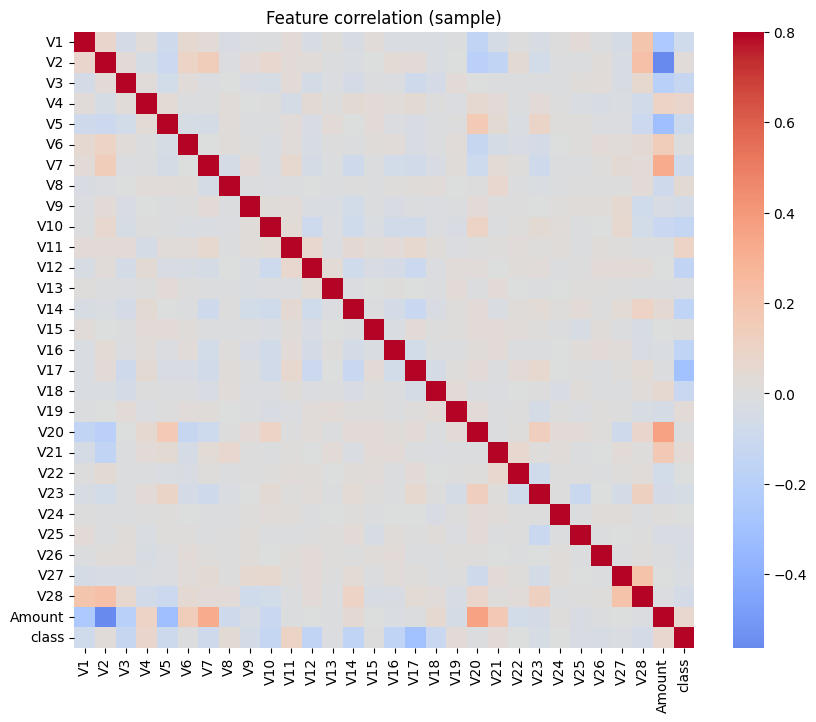

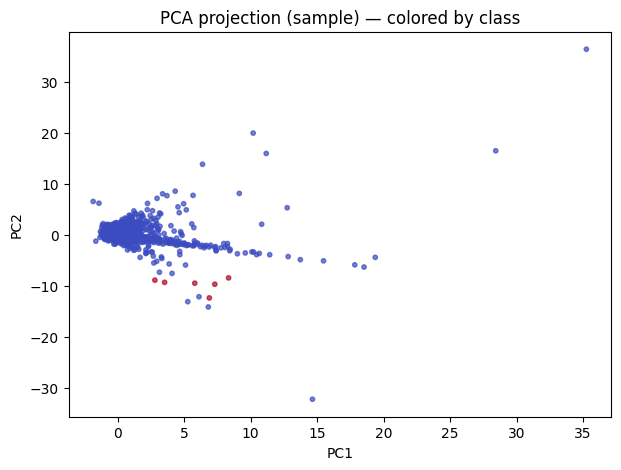

In [4]:
# Basic EDA (runs only if data loaded)
if credit_df is None:
    print('Credit dataset not loaded. Skipping EDA.')
else:
    df = credit_df.copy()
    # Standardize common column names if needed
    if 'Class' in df.columns:
        df.rename(columns={'Class':'class'}, inplace=True)
    # Inspect
    df['class'] = pd.to_numeric(df['class'], errors='coerce')
    display(df.head())
    display(df.describe().T)
    print('\nValue counts for class (1=fraud):')
    print(df['class'].value_counts(dropna=False))
    # Percent fraud
    fraud_ratio = df['class'].mean()
    print(f'Fraud ratio: {fraud_ratio:.6f} (fraction of rows labelled 1)')
    # Correlation heatmap (sampled for speed)
    sample = df.sample(min(5000, len(df)), random_state=42)
    plt.figure(figsize=(10,8))
    sns.heatmap(sample.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', center=0, vmax=0.8)
    plt.title('Feature correlation (sample)')
    plt.show()
    # PCA visualization colored by class (for numeric features)
    numeric = sample.select_dtypes(include=[np.number]).fillna(0)
    cols = numeric.columns.tolist()
    Xnum = numeric[cols].values
    Xnum = (Xnum - Xnum.mean(axis=0)) / (Xnum.std(axis=0) + 1e-9)
    pca = PCA(n_components=2)
    proj = pca.fit_transform(Xnum)
    plt.figure(figsize=(7,5))
    plt.scatter(proj[:,0], proj[:,1], c=sample['class'], s=10, cmap='coolwarm', alpha=0.7)
    plt.title('PCA projection (sample) — colored by class')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

### 3.2 Preprocessing & Splits

We’ll prepare features for unsupervised anomaly detection. We treat the minority fraud class as ‘anomalies’ for evaluation. We scale numeric features and create train/test splits. Training for unsupervised methods will use mostly normal samples to simulate realistic scenarios.

In [5]:
if credit_df is None:
    print('Credit dataset not loaded — cannot continue preprocessing.')
else:
    df = credit_df.copy()
    if 'Class' in df.columns:
        df.rename(columns={'Class':'class'}, inplace=True)
    # Identify numeric columns (drop identifiers if present)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numeric_cols:
        numeric_cols.remove('class')
    X = df[numeric_cols].fillna(0).values
    y = df['class'].astype(int).values  # 1 indicates fraud in the usual creditcard dataset
    print('Numeric features:', len(numeric_cols))
    print('Total samples:', X.shape[0], 'Positive (fraud):', y.sum())
    # scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
    # For unsupervised training (e.g., autoencoder), keep mainly normal in train
    X_train_norm = X_train[y_train==0]
    print('Train normal samples:', X_train_norm.shape[0])

Numeric features: 29
Total samples: 284807 Positive (fraud): 492
Train normal samples: 170589


### 3.3 Comparing Anomaly Detection Methods

We’ll implement and compare:
- IsolationForest (tree-based)
- Gaussian Mixture Model (GMM, statistical/probabilistic)
- One-Class SVM (kernel)
- Keras Autoencoder (deep reconstruction, if TF available)

Each method will produce a continuous anomaly score and we will evaluate using ROC-AUC and PR-AUC.

In [6]:
if credit_df is None:
    print('Credit dataset not loaded — skipping model runs.')
else:
    results = {}
    # Isolation Forest
    print('Training IsolationForest...')
    iso = IsolationForest(n_estimators=200, contamination=y.mean(), random_state=42, n_jobs=-1)
    iso.fit(X_train)  # unsupervised
    iso_scores = -iso.decision_function(X_test)  # higher -> more anomalous
    results['IsolationForest'] = evaluate_continuous(y_test, iso_scores)
    print('IsolationForest done.')

    # GMM (Probabilistic Anomaly Detection)
    print('Training GMM on train data...')
    # We use 5 components, assuming the normal data distribution can be modeled by a mixture of 5 Gaussians
    gmm = GaussianMixture(n_components=5, random_state=42)
    gmm.fit(X_train_norm)
    # Anomaly score is the negative log-likelihood (lower log-prob -> higher anomaly score)
    gmm_scores = -gmm.score_samples(X_test)
    results['GMM'] = evaluate_continuous(y_test, gmm_scores)
    print('GMM done.')

    # One-Class SVM
    print('Training One-Class SVM...')
    oc = OneClassSVM(kernel='rbf', gamma='scale', nu=0.0015)  # nu should be small for rare anomalies
    oc.fit(X_train_norm)
    oc_scores = -oc.decision_function(X_test)
    results['OneClassSVM'] = evaluate_continuous(y_test, oc_scores)
    print('One-Class SVM done.')

    # Keras Autoencoder (if available)
    if TF_AVAILABLE:
        print('Training Keras autoencoder (deep reconstruction)...')
        input_dim = X_train_norm.shape[1]
        latent_dim = min(16, max(8, input_dim//8))
        inp = keras.Input(shape=(input_dim,))
        x = layers.Dense(64, activation='relu')(inp)
        x = layers.Dense(32, activation='relu')(x)
        lat = layers.Dense(latent_dim, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(lat)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(input_dim, activation='linear')(x)
        auto = keras.Model(inp, out)
        auto.compile(optimizer='adam', loss='mse')
        # Train on normal data only
        history = auto.fit(X_train_norm, X_train_norm, epochs=30, batch_size=256, validation_split=0.1, verbose=0)
        # reconstruction errors on test
        X_test_pred = auto.predict(X_test)
        recon_err = np.mean(np.square(X_test - X_test_pred), axis=1)
        results['KerasAutoencoder'] = evaluate_continuous(y_test, recon_err)
        print('Keras autoencoder done.')


    # Summarize results
    print('\nMethod performance summary (ROC-AUC / PR-AUC):')
    for k,v in results.items():
        print(f'{k}: ROC-AUC={v["roc_auc"]:.4f}, PR-AUC={v["pr_auc"]:.4f}')

Training IsolationForest...
IsolationForest done.
Training GMM on train data...
GMM done.
Training One-Class SVM...
One-Class SVM done.
Training Keras autoencoder (deep reconstruction)...


W0000 00:00:1763115367.918466   13523 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 665us/step
Keras autoencoder done.

Method performance summary (ROC-AUC / PR-AUC):
IsolationForest: ROC-AUC=0.9512, PR-AUC=0.1281
GMM: ROC-AUC=0.9418, PR-AUC=0.7111
OneClassSVM: ROC-AUC=0.9371, PR-AUC=0.3117
KerasAutoencoder: ROC-AUC=0.9438, PR-AUC=0.3669


### 3.4 Visualize Scores & Precision-Recall Curves

Plot score distributions for top methods and PR curves to compare.

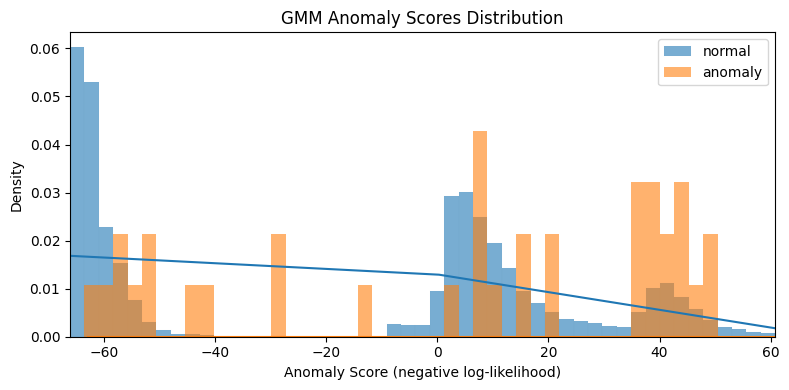

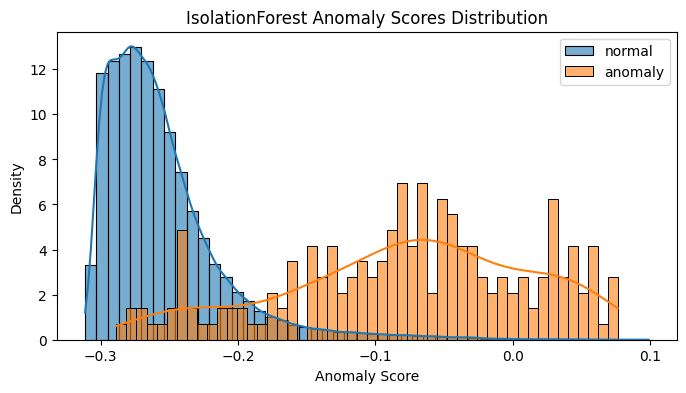


ANOMALY DETECTION PERFORMANCE SUMMARY
Method                  ROC-AUC     PR-AUC
------------------------------------------------------------
GMM                      0.9418     0.7111
KerasAutoencoder         0.9438     0.3669
OneClassSVM              0.9371     0.3117
IsolationForest          0.9512     0.1281


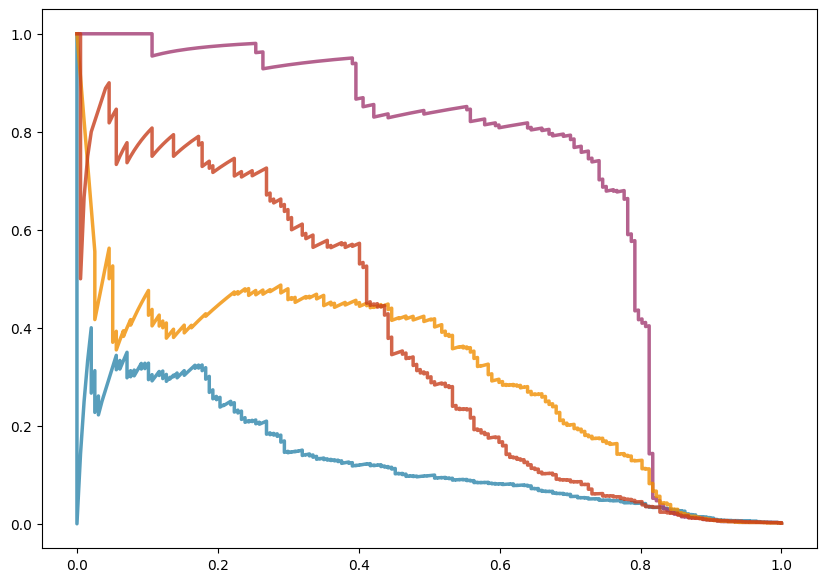

In [ ]:
if credit_df is None:
    print('Credit dataset not loaded — skipping visualization.')
else:
    # Plot score distributions with improved handling for GMM
    if 'GMM' in results:
        plt.figure(figsize=(8,4))
        normal_scores = gmm_scores[y_test==0]
        anomaly_scores = gmm_scores[y_test==1]

        # Use percentile-based bins to handle outliers
        cov_types = np.linspace(
            np.percentile(gmm_scores, 1),
            np.percentile(gmm_scores, 99),
            50
        )

        sns.histplot(normal_scores, bins=cov_types, label='normal', stat='density', alpha=0.6, kde=True)
        sns.histplot(anomaly_scores, bins=cov_types, label='anomaly', stat='density', alpha=0.6, kde=True)
        plt.legend()
        plt.title('GMM Anomaly Scores Distribution')
        plt.xlabel('Anomaly Score (negative log-likelihood)')
        plt.ylabel('Density')
        plt.xlim(np.percentile(gmm_scores, 1), np.percentile(gmm_scores, 99))
        plt.tight_layout()
        plt.show()

    if 'IsolationForest' in results:
        plot_score_vs_label(iso_scores, y_test, title='IsolationForest Anomaly Scores Distribution')

    # Plot PR curves
    plt.figure(figsize=(10, 7))

    # Define colors for consistency
    colors = {'IsolationForest': '#2E86AB', 'GMM': '#A23B72',
              'OneClassSVM': '#F18F01', 'KerasAutoencoder': '#C73E1D'}

    for name, score_dict in results.items():
        if name == 'KerasAutoencoder' and not TF_AVAILABLE:
            continue
        # Get scores for plotting PR curve
        if name == 'IsolationForest':
            scores = iso_scores
        elif name == 'GMM':
            scores = gmm_scores
        elif name == 'OneClassSVM':
            scores = oc_scores
        elif name == 'KerasAutoencoder':
            scores = recon_err

        precision, recall, _ = precision_recall_curve(y_test, scores)
        plt.plot(recall, precision,
                label=f'{name} (AUC={score_dict["pr_auc"]:.3f})',
                linewidth=2.5,
                color=colors.get(name, None),
                alpha=0.8)

    # Print summary table
    print('\n' + '='*60)
    print('ANOMALY DETECTION PERFORMANCE SUMMARY')
    print('='*60)
    print(f'{"Method":<20} {"ROC-AUC":>10} {"PR-AUC":>10}')
    print('-'*60)
    for name, score_dict in sorted(results.items(), key=lambda x: x[1]['pr_auc'], reverse=True):
        print(f'{name:<20} {score_dict["roc_auc"]:>10.4f} {score_dict["pr_auc"]:>10.4f}')
    print('='*60)

## 4. Distribution Drift Analysis (Part B: Electricity Data)

### 4.1 Data Preparation for Drift

We use the electricity dataset to simulate a time-series environment where the underlying data distribution may change over time. We will focus on the `nswprice` column as the primary variable for drift detection.

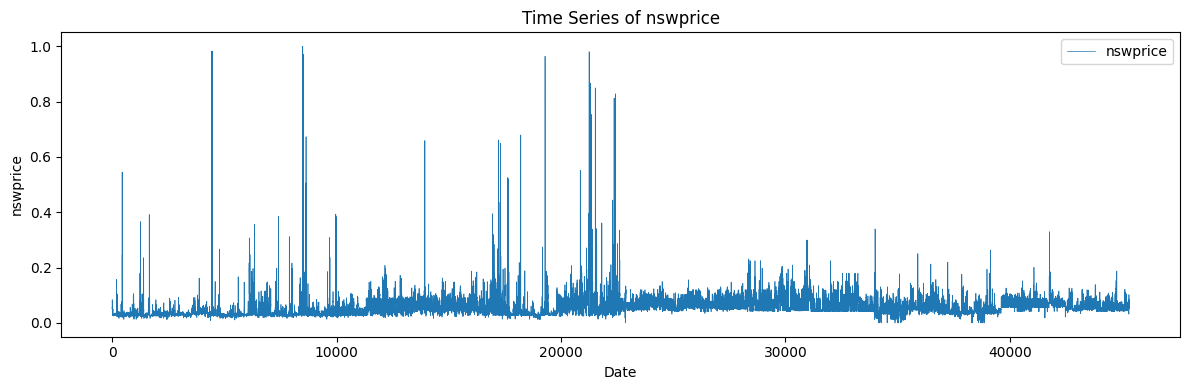

Data shape: (45312, 8)
nswprice statistics: mean=0.06, std=0.04


In [8]:
if electric_df is None:
    print('Electricity dataset not loaded — cannot continue with drift analysis.')
else:
    # Clean up and prepare the electricity data
    edf = electric_df.copy()
    # Standardize column names
    if 'class' in edf.columns:
        edf.drop(columns=['class'], inplace=True) # Drop the target variable if it exists

    # Identify time and value columns
    time_col = 'date'
    value_col = 'nswprice'
    if time_col in edf.columns:
        try:
            edf[time_col] = pd.to_datetime(edf[time_col], errors='coerce')
            edf = edf.dropna(subset=[time_col])  # Drop rows with invalid dates
            edf.sort_values(by=time_col, inplace=True)
            edf.reset_index(drop=True, inplace=True)
        except Exception as e:
            print(f"Warning: Could not convert '{time_col}' to datetime: {e}")
            # Use index as time
            edf['time_index'] = np.arange(len(edf))
            time_col = 'time_index'

    # Plot the time series
    plt.figure(figsize=(12, 4))
    if time_col == 'date':
        plt.plot(edf.index, edf[value_col], label=value_col, linewidth=0.5)
    else:
        plt.plot(edf[time_col], edf[value_col], label=value_col, linewidth=0.5)
    plt.title(f'Time Series of {value_col}')
    plt.xlabel('Time Index' if time_col != 'date' else 'Date')
    plt.ylabel(value_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'Data shape: {edf.shape}')
    print(f'{value_col} statistics: mean={edf[value_col].mean():.2f}, std={edf[value_col].std():.2f}')

### 4.2 Drift Detection using Wasserstein Distance

We will implement a sliding-window approach to detect drift in the distribution of the `nswprice` feature. The Wasserstein distance (Earth Mover's Distance) is a robust metric for comparing probability distributions.

We compare the distribution of a **reference window** (the first 1000 samples) against a **test window** (a sliding window of 500 samples).

Starting sliding window drift analysis...


100%|██████████| 439/439 [00:00<00:00, 4500.90it/s]


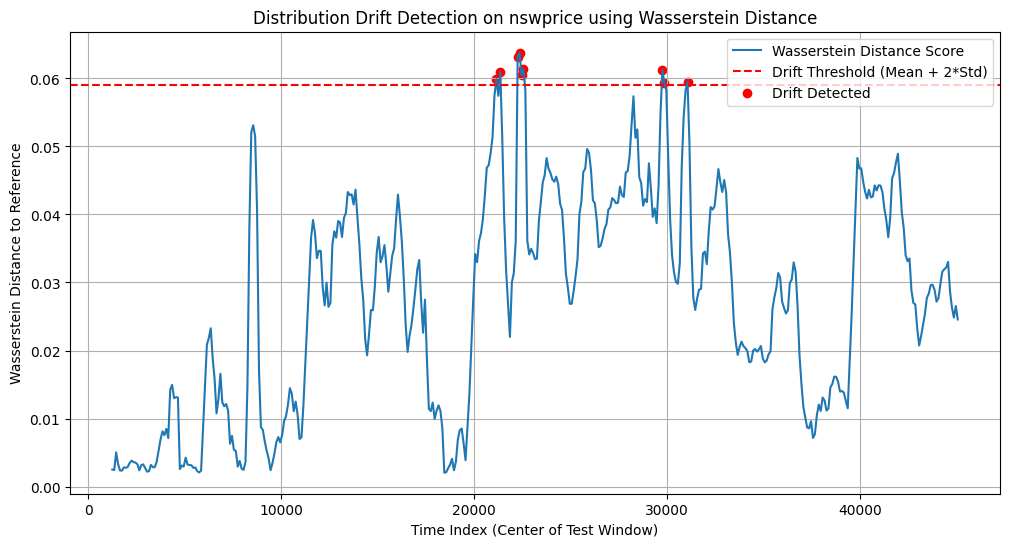


Drift detected at 9 points.
First drift point index: 21150


In [9]:
if electric_df is None:
    print('Electricity dataset not loaded — skipping drift detection.')
else:
    # Parameters for drift detection
    REF_WINDOW_SIZE = 1000
    TEST_WINDOW_SIZE = 500
    STEP_SIZE = 100

    # Extract the feature values
    data = edf[value_col].values.astype(float)

    # Define the reference distribution (first 1000 samples)
    ref_data = data[:REF_WINDOW_SIZE]

    # Initialize lists to store results
    drift_scores = []
    window_indices = []

    # Sliding window analysis
    print('Starting sliding window drift analysis...')
    for i in tqdm(range(REF_WINDOW_SIZE, len(data) - TEST_WINDOW_SIZE, STEP_SIZE)):
        test_data = data[i:i + TEST_WINDOW_SIZE]

        # Calculate Wasserstein distance
        # Note: The data must be 1D arrays for scipy.stats.wasserstein_distance
        distance = wasserstein_distance(ref_data, test_data)

        drift_scores.append(distance)
        window_indices.append(i + TEST_WINDOW_SIZE // 2) # Center of the test window

    # Convert to numpy arrays for easier analysis
    drift_scores = np.array(drift_scores)
    window_indices = np.array(window_indices)

    # Define a simple threshold for drift alert
    mean_score = np.mean(drift_scores)
    std_score = np.std(drift_scores)
    drift_threshold = mean_score + 2 * std_score

    # Plotting the drift scores
    plt.figure(figsize=(12, 6))
    plt.plot(window_indices, drift_scores, label='Wasserstein Distance Score')
    plt.axhline(drift_threshold, color='r', linestyle='--', label=f'Drift Threshold (Mean + 2*Std)')

    # Mark drift points
    drift_points = window_indices[drift_scores > drift_threshold]
    plt.scatter(drift_points, drift_scores[drift_scores > drift_threshold], color='red', marker='o', label='Drift Detected')

    plt.title(f'Distribution Drift Detection on {value_col} using Wasserstein Distance')
    plt.xlabel('Time Index (Center of Test Window)')
    plt.ylabel('Wasserstein Distance to Reference')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'\nDrift detected at {len(drift_points)} points.')
    if len(drift_points) > 0:
        print('First drift point index:', drift_points[0])

### 4.3 Performance-Based Drift Detection with DDM and Incremental Learning

In this section, we implement a **performance-based drift detection** strategy using the Drift Detection Method (DDM) in an incremental learning approach. We train an initial model on a reference window and continuously monitor error rates on incoming batches. DDM tracks the error rate and its standard deviation, detecting warnings and drifts based on statistical thresholds, triggering retraining when confirmed drift occurs.

**Key Concepts:**
- **Prequential Evaluation**: Test-then-train paradigm where each sample is first used for testing, then for training.
- **DDM Monitoring**: Tracks minimum error rate (p_min) and std (s_min); detects warning at p_t + s_t >= p_min + 2*s_min, drift at >= 3*s_min.
- **Adaptive Retraining**: Retrain model on recent window upon drift detection and reset DDM statistics.

Starting prequential evaluation with DDM drift detection...


  0%|          | 0/448 [00:00<?, ?it/s]

100%|██████████| 448/448 [00:07<00:00, 56.96it/s]


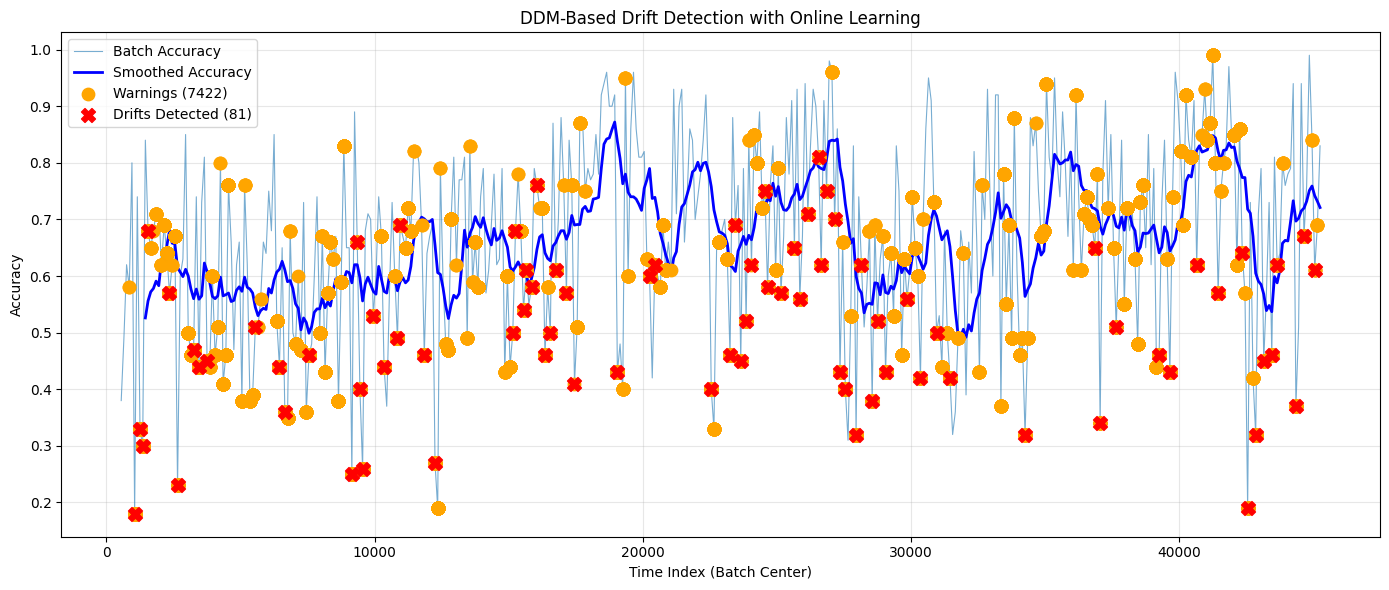


Drifts detected at 81 points.
Mean accuracy: 0.6653
Std accuracy: 0.1686


In [10]:
if electric_df is None:
    print('Electricity dataset not loaded — skipping performance-based drift detection.')
else:
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score
    import math  # For sqrt

    # Prepare data: use 'class' as target (UP/DOWN electricity price movement)
    # If 'class' column exists in original dataset
    edf_full = electric_df.copy()

    # Map string labels to integers for consistency
    if 'class' in edf_full.columns and edf_full['class'].dtype == object:
        edf_full['class'] = edf_full['class'].map({'DOWN': 0, 'UP': 1}).astype(int)

    # Create feature matrix and target
    feature_cols = ['nswdemand', 'vicprice', 'vicdemand', 'transfer']
    available_features = [col for col in feature_cols if col in edf_full.columns]

    if len(available_features) < 2 or 'class' not in edf_full.columns:
        print("Warning: Not enough features or no 'class' column. Creating synthetic target.")
        # Create synthetic binary target based on price change
        edf_full = edf_full.sort_values('date').reset_index(drop=True)
        edf_full['price_change'] = edf_full['nswprice'].diff()
        edf_full['class'] = (edf_full['price_change'] > 0).astype(int)
        edf_full = edf_full.dropna()

    X_stream = edf_full[available_features].fillna(0).values
    y_stream = edf_full['class'].values

    # Parameters
    INITIAL_TRAIN_SIZE = 500
    BATCH_SIZE = 100
    MIN_INSTANCES = 100  # Min samples before DDM stats stabilize

    # Initialize model and scaler
    scaler_online = StandardScaler()
    X_train_init = scaler_online.fit_transform(X_stream[:INITIAL_TRAIN_SIZE])
    y_train_init = y_stream[:INITIAL_TRAIN_SIZE]
    model = SGDClassifier(loss='log_loss', random_state=42, max_iter=1)
    model.fit(X_train_init, y_train_init)

    # DDM variables
    p_min = float('inf')  # Min error rate
    s_min = float('inf')  # Min std
    p_current = 0  # Current error rate
    s_current = 0  # Current std
    t = 0  # Instance count for DDM

    # Track performance
    accuracies = []
    batch_indices = []
    drift_detected_at = []
    warning_at = []  # For warnings

    print('Starting prequential evaluation with DDM drift detection...')

    for i in tqdm(range(INITIAL_TRAIN_SIZE, len(X_stream) - BATCH_SIZE, BATCH_SIZE)):
        X_batch = X_stream[i:i+BATCH_SIZE]
        y_batch = y_stream[i:i+BATCH_SIZE]
        X_batch_scaled = scaler_online.transform(X_batch)

        # Predict and get error
        y_pred = model.predict(X_batch_scaled)
        batch_acc = accuracy_score(y_batch, y_pred)
        batch_error = 1 - batch_acc
        accuracies.append(batch_acc)
        batch_indices.append(i + BATCH_SIZE // 2)

        # Update DDM per instance (simulate stream)
        for error in (y_pred != y_batch):  # Per-sample error (1 or 0)
            t += 1
            p_current = p_current + (error - p_current) / t
            s_current = math.sqrt(p_current * (1 - p_current) / t)

            if t > MIN_INSTANCES:
                if p_current + s_current < p_min + s_min:
                    p_min = p_current
                    s_min = s_current
                if p_current + s_current >= p_min + 2 * s_min:
                    warning_at.append(i + BATCH_SIZE // 2)
                if p_current + s_current >= p_min + 3 * s_min:
                    drift_detected_at.append(i + BATCH_SIZE // 2)

                    # Retrain on recent window
                    retrain_window = 1000
                    retrain_start = max(0, i - retrain_window)
                    X_retrain = scaler_online.fit_transform(X_stream[retrain_start:i+BATCH_SIZE])
                    y_retrain = y_stream[retrain_start:i+BATCH_SIZE]
                    model = SGDClassifier(loss='log_loss', random_state=42, max_iter=10)
                    model.fit(X_retrain, y_retrain)

                    # Reset DDM
                    p_min = float('inf')
                    s_min = float('inf')
                    p_current = 0
                    s_current = 0
                    t = 0

        # Incremental train
        model.partial_fit(X_batch_scaled, y_batch, classes=np.unique(y_stream))

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(batch_indices, accuracies, label='Batch Accuracy', alpha=0.6, linewidth=0.8)

    # Smooth line
    window_size = 10
    if len(accuracies) >= window_size:
        smoothed = np.convolve(accuracies, np.ones(window_size)/window_size, mode='valid')
        smooth_indices = batch_indices[window_size-1:]
        plt.plot(smooth_indices, smoothed, label='Smoothed Accuracy', linewidth=2, color='blue')

    if len(warning_at) > 0:
        warning_accs = [accuracies[batch_indices.index(w)] for w in warning_at if w in batch_indices]
        plt.scatter(warning_at, warning_accs, color='orange', s=80, marker='o', label=f'Warnings ({len(warning_at)})', zorder=4)
    if len(drift_detected_at) > 0:
        drift_accs = [accuracies[batch_indices.index(d)] for d in drift_detected_at if d in batch_indices]
        plt.scatter(drift_detected_at, drift_accs, color='red', s=100, marker='X', label=f'Drifts Detected ({len(drift_detected_at)})', zorder=5)

    plt.title('DDM-Based Drift Detection with Online Learning')
    plt.xlabel('Time Index (Batch Center)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f'\nDrifts detected at {len(drift_detected_at)} points.')
    print(f'Mean accuracy: {np.mean(accuracies):.4f}')
    print(f'Std accuracy: {np.std(accuracies):.4f}')

## 5. Model Robustness: Adversarial Simulation (Label-Flip Poisoning)

Simulate flipping labels on a small fraction of the training data and measure degradation on a clean test set for a supervised classifier (LogisticRegression). This section uses the Credit Card data.

In [11]:
from sklearn.linear_model import LogisticRegression
if credit_df is None:
    print('Credit dataset not loaded — skipping poisoning simulation.')
else:
    # We need to re-run the preprocessing section to get X_train, y_train, X_test, y_test
    # (Assuming the preprocessing cell 3.2 has been run)

    # Supervised baseline
    clf = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    base_f1 = f1_score(y_test, y_pred)
    print('Baseline supervised F1:', base_f1)

    # Poisoning: flip labels of small random subset of training data
    rng = np.random.RandomState(42)
    poison_frac = 0.05  # 5%
    n_poison = int(poison_frac * len(y_train))
    idx = rng.choice(np.arange(len(y_train)), size=n_poison, replace=False)
    y_train_poison = y_train.copy()
    y_train_poison[idx] = 1 - y_train_poison[idx]  # flip

    clf2 = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
    clf2.fit(X_train, y_train_poison)
    y_pred2 = clf2.predict(X_test)
    poisoned_f1 = f1_score(y_test, y_pred2)
    print(f'After flipping {poison_frac*100:.1f}% of training labels, F1 ->', poisoned_f1)
    print('Relative drop in F1:', (base_f1 - poisoned_f1) / (base_f1 + 1e-9))

Baseline supervised F1: 0.7422096317280453
After flipping 5.0% of training labels, F1 -> 0.6747720364741642
Relative drop in F1: 0.09086057668910788


## 6. Student Tasks
These tasks are designed for deeper exploration of the concepts covered in this lab, focusing on hyperparameter tuning, model comparison, and practical application of anomaly detection and drift adaptation.


### Exercise 1: Hyperparameter Tuning
Optimize the hyperparameters of IsolationForest and GaussianMixture for anomaly detection on the Credit Card Fraud dataset. Report improved metrics and discuss trade-offs (e.g., computation time vs. accuracy).

In [ ]:
if credit_df is None:
    print('Credit dataset not loaded!')
else:
    results = {}
    # Isolation Forest
    print('Training IsolationForest...')
    
    for estimators in range(50, 301, 50):
        print(f"Training with {estimators} estimators")
        iso = IsolationForest(n_estimators=estimators, contamination=y.mean(), random_state=42, n_jobs=-1)
        ti = time.time()
        iso.fit(X_train)  # unsupervised
        tf = time.time()
        iso_scores = -iso.decision_function(X_test)  # higher -> more anomalous
        results[f'IsolationForest_{estimators}'] = evaluate_continuous(y_test, iso_scores)
        results[f'IsolationForest_{estimators}'] = evaluate_continuous(y_test, iso_scores)
        results[f'IsolationForest_{estimators}']["time"] = tf - ti
    print('IsolationForest done.')

    # GMM (Probabilistic Anomaly Detection)
    print('Training GMM on train data...')

    # We use 5 components, assuming the normal data distribution can be modeled by a mixture of 5 Gaussians
    for components in range(2, 11, 2):
        for cov_type in ('full', 'tied', 'diag', 'spherical'):
            print(f'Training GMM with {components} components and {cov_type} covariance type')
            gmm = GaussianMixture(n_components=components, covariance_type=cov_type, random_state=42)
            ti = time.time()
            gmm.fit(X_train_norm)
            tf = time.time()
            # Anomaly score is the negative log-likelihood (lower log-prob -> higher anomaly score)
            gmm_scores = -gmm.score_samples(X_test)
            results[f'GMM_{components}_{cov_type}'] = evaluate_continuous(y_test, gmm_scores)
            results[f'GMM_{components}_{cov_type}']["time"] = tf - ti
    print('GMM done.')

Training IsolationForest...
Training with 50 estimators
Training with 100 estimators
Training with 150 estimators
Training with 200 estimators
Training with 250 estimators
Training with 300 estimators
IsolationForest done.
Training GMM on train data...
Training GMM with 2 components and full covariance type
Training GMM with 2 components and tied covariance type
Training GMM with 2 components and diag covariance type
Training GMM with 2 components and spherical covariance type
Training GMM with 4 components and full covariance type
Training GMM with 4 components and tied covariance type
Training GMM with 4 components and diag covariance type
Training GMM with 4 components and spherical covariance type
Training GMM with 6 components and full covariance type
Training GMM with 6 components and tied covariance type
Training GMM with 6 components and diag covariance type
Training GMM with 6 components and spherical covariance type
Training GMM with 8 components and full covariance type
Trai

0


Method performance summary (ROC-AUC / PR-AUC):
IsolationForest_50            : ROC-AUC=0.9462, PR-AUC=0.1176
IsolationForest_100           : ROC-AUC=0.9494, PR-AUC=0.1220
IsolationForest_150           : ROC-AUC=0.9507, PR-AUC=0.1257
IsolationForest_200           : ROC-AUC=0.9512, PR-AUC=0.1281
IsolationForest_250           : ROC-AUC=0.9541, PR-AUC=0.1514
IsolationForest_300           : ROC-AUC=0.9540, PR-AUC=0.1616
GMM_2_full                    : ROC-AUC=0.9396, PR-AUC=0.6397
GMM_2_tied                    : ROC-AUC=0.9561, PR-AUC=0.4755
GMM_2_diag                    : ROC-AUC=0.9552, PR-AUC=0.2781
GMM_2_spherical               : ROC-AUC=0.9530, PR-AUC=0.1403
GMM_4_full                    : ROC-AUC=0.9404, PR-AUC=0.7104
GMM_4_tied                    : ROC-AUC=0.9592, PR-AUC=0.4774
GMM_4_diag                    : ROC-AUC=0.9597, PR-AUC=0.2870
GMM_4_spherical               : ROC-AUC=0.9546, PR-AUC=0.1465
GMM_6_full                    : ROC-AUC=0.9423, PR-AUC=0.6763
GMM_6_tied            

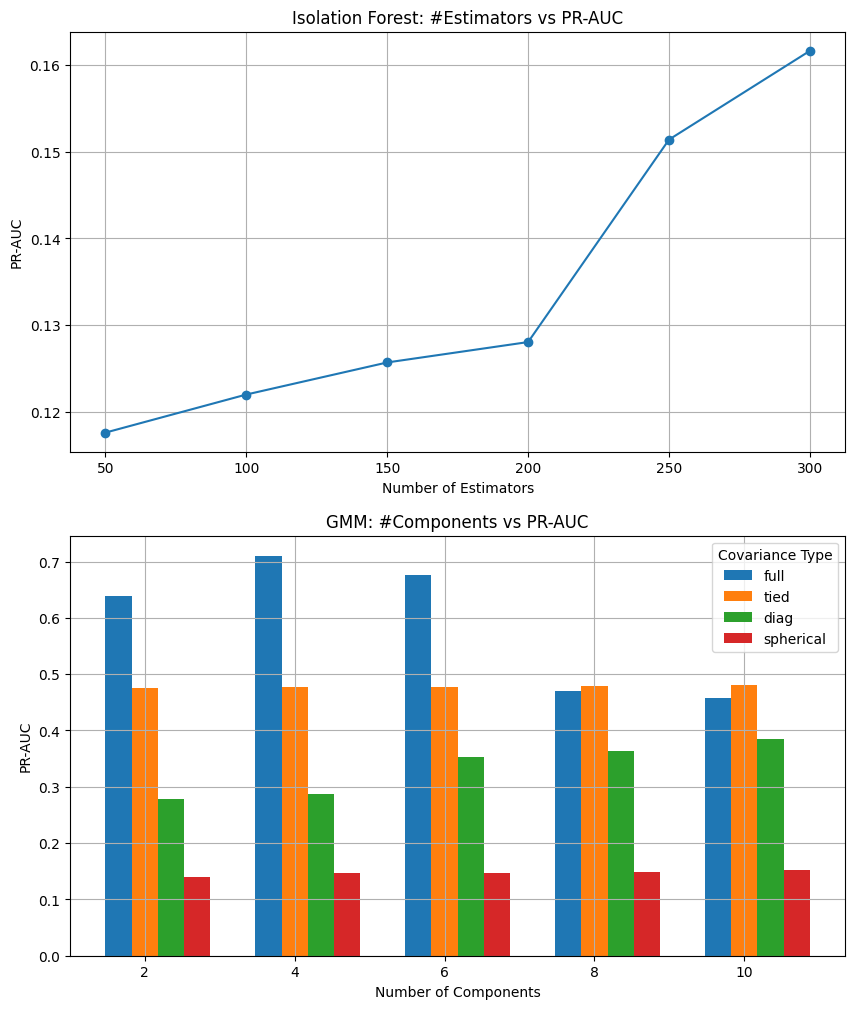

In [ ]:
if results:
    # Summarize results
    print('\nMethod performance summary (ROC-AUC / PR-AUC):')
    for k,v in results.items():
        print(f'{k:<30}: ROC-AUC={v["roc_auc"]:.4f}, PR-AUC={v["pr_auc"]:.4f}')
    
    iso_estimators = []
    iso_pr_aucs = []
    for k,v in results.items():
        if k.startswith('IsolationForest_'):
            parts = k.split('_')
            iso_estimators.append(int(parts[1]))
            iso_pr_aucs.append(v['pr_auc'])
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    subplot1 = ax[0]
    # Plot of # estimators vs PR-AUC for Isolation Forest
    subplot1.plot(iso_estimators, iso_pr_aucs, marker='o')
    subplot1.set_title('Isolation Forest: #Estimators vs PR-AUC')
    subplot1.set_xlabel('Number of Estimators')
    subplot1.set_ylabel('PR-AUC')
    subplot1.grid(True)

    # Plot of # components vs PR-AUC for GMM
    subplot2 = ax[1]
    width = 0.35
    x_by_cov = {}
    y_by_cov = {}

    # Eww
    for k, v in results.items():
        if not k.startswith("GMM_"):
            continue

        _, comp, cov = k.split("_")
        comp = int(comp)
        auc = v["pr_auc"]

        x_by_cov[cov] = x_by_cov.get(cov, []) + [comp]
        y_by_cov[cov] = y_by_cov.get(cov, []) + [auc]

    multiplier = 0
    for cov in x_by_cov.keys():
        multiplier += 1
        offset = width * (multiplier - len(x_by_cov) / 2)
        subplot2.bar([c + offset for c in x_by_cov[cov]], y_by_cov[cov], width=width, label=cov)

    subplot2.legend(title='Covariance Type')
    subplot2.set_title('GMM: #Components vs PR-AUC')
    subplot2.set_xlabel('Number of Components')
    subplot2.set_ylabel('PR-AUC')
    subplot2.grid(True)

### Exercise 2: Drift Mitigation Comparison

Implement and compare two mitigation methods for handling drifts in the Elec2 dataset:  
(1) **Passive approach**: Periodic retraining every N batches (e.g., N=10).  
(2) **Active approach**: Triggered retraining on detected drifts using ADWIN (extend the DDM section by replacing it with an ADWIN implementation); reference: https://riverml.xyz/dev/api/drift/ADWIN/.

Track overall accuracy and F1-score over the stream, plot the results for both approaches.

### Exercise 3: Implement Poisoning Defense
Extend the label-flip poisoning simulation by implementing a defense: Use IsolationForest on X_train to detect and remove potential poisoned samples from the poisoned training data (y_train_poison). Retrain the model on the cleaned data and compare performance to the undefended poisoned case using multiple metrics (F1, MCC, Precision, Recall, and PR-AUC). Plot relative drops in these metrics and discuss which metric best captures the degradation and recovery.